### Import dependencies

In [225]:
import pandas as pd
import numpy as np

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

from sklearn import linear_model as lm


import os
import matplotlib.pyplot as plt
import cProfile


### Setup

In [415]:
def path_to_symbols(base_dir="data"):
    """Return a list of symbols from a directory by removing the file extension `csv`."""
    file_list = os.listdir(base_dir)
    res =[]

    for file in file_list:
        file = file.split('.')
        if file[1] =="csv":
            res.append(file[0])
    return res
        
def symbol_to_path(symbol, base_dir= "data"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df_container = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')
    
    


    
    if len(symbols) > 1:
        for symbol in symbols:
            if symbol == "SPY":
                df_temp = pd.read_csv("data/" + "SPY" + ".csv", index_col= "Date", parse_dates= True, usecols=['Date', 'Adj Close'], na_values="nan")
                df_temp = df_temp.rename(columns={'Adj Close':"SPY"})
                df_container = df_container.join(df_temp)
                df_container = df_container.dropna();
            else:
            
                df_temp = pd.read_csv("data/" + symbol + ".csv", index_col= "Date", parse_dates= True, usecols=['Date', 'Adj Close'], na_values="nan")
                df_temp = df_temp.rename(columns={'Adj Close':symbol})
                df_container = df_container.join(df_temp)
    else:
        df_temp = pd.read_csv("data/" + symbols[0] + ".csv", index_col= "Date", parse_dates= True, usecols=['Date', 'Adj Close'], na_values="nan")
        df_temp = df_temp.rename(columns={'Adj Close':symbols[0]})
        df_container = df_container.join(df_temp)

    return df_container

def normalise_data(df:pd.DataFrame, frame_of_reference= 0):
    """Normalises the data based on the frame of reference"""
    return df/df.iloc[frame_of_reference]

def get_rolling_mean(df:pd.DataFrame, window = 20):
    return df.rolling(window).mean()

def get_rolling_std(df:pd.DataFrame, window = 20):
    return df.rolling(window).std()

def get_bollinger_bands(df:pd.DataFrame, window = 20, num_std = 2):
    """ Returns a tuple of Bollinger Bands® `(upper band, rolling mean , lower band)`"""

    rolling_mean = get_rolling_mean(df, window)
    std = get_rolling_std(df, window)
    upper_band = rolling_mean + num_std * std
    lower_band = rolling_mean - num_std * std

    return (upper_band, rolling_mean, lower_band)

def get_daily_returns(df:pd.DataFrame):
    df_lag = df.shift(1)
    df_res = ((df/df_lag) - 1) * 100

    df_res = df_res.fillna(0)

    return df_res

def fill_missing_values(df):
    df.ffill(axis=0, inplace=True)
    df.bfill(axis=0, inplace=True)

def create_regression(df:pd.DataFrame, window=100):
    """
    `df`dataframe to create regression from
    `window` the number of days from the dataframe to consider in the regression
    
    """
    # TODO: make this seperate every col in df and create its regression individually
    res = df.tail(window)
    
    res = res.reset_index(drop=True, inplace=False)
    res.insert(0, 'index',res.index)

    temp_array = res.to_numpy()


    temp_array = np.transpose(temp_array) 
    
    reg = lm.LinearRegression()
    
    reg.fit(temp_array[0].reshape(-1, 1) ,temp_array[1])

    x = np.linspace(int(temp_array[0][0])+1, int(temp_array[0][-1])+1 + window, window+window+1)
    b = reg.intercept_
    m = reg.coef_
    y = m * x + b
    # print(temp_array[0][0])

    # print(y)
    # print(m)
    # print(x)
    # print(b)

    last_date = df.index[-1]
    new_end_date = last_date + pd.DateOffset(days=window)
    new_date_range = pd.date_range(start=last_date, end=new_end_date, freq='D')



    # Plot the data points
    fin = df.tail(window)

    fin = pd.concat([fin, pd.DataFrame(index=new_date_range)])

    print(len(y))
    print(y)
    print(len(fin))

    fin.insert(0, "regression", y)
    # fin.pop("SPY")

    print(fin)

    return fin


    

def test_run():
    # Define a date range
    dates = pd.date_range('2010-01-01', '2010-12-30')
    # dates = pd.date_range('2006-01-01', '2013-12-30')

    # Choose stock symbols to read
    symbols = path_to_symbols()
    # print(symbols)
    symbols = [symbols[4]]
    # symbols = symbols[1:]
    
    # Get stock data
    df = get_data(symbols, dates)
    fill_missing_values(df)
    
    df = normalise_data(df)
    

    # compute rolling mean 
    window = 20
    bb = get_bollinger_bands(df, window)
    ub_df = bb[0]
    rm_df = bb[1]
    lb_df = bb[2]

    # ub_df.plot(label="upper mean", ax=ax)
    # rm_df.plot(label="rolling mean", ax=ax)
    # lb_df.plot(label="lower mean", ax=ax)
    
    
    # generating regression
    reg_df = create_regression(df, window=3)

    # PLOTTING DATA
    ax = df.plot(title="normalised price")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

    bx = get_daily_returns(df).plot(title="daily returns")
    bx.set_xlabel("Date")
    bx.set_ylabel("Price")

    cx = reg_df.plot(title="Predicted")

    
    







7
[1.13203352 1.13162106 1.1312086  1.13079613 1.13038367 1.12997121
 1.12955875]
7
            regression       SPY
2010-12-28    1.132034  1.132094
2010-12-29    1.131621  1.132903
2010-12-30    1.131209  1.131104
2010-12-30    1.130796       NaN
2010-12-31    1.130384       NaN
2011-01-01    1.129971       NaN
2011-01-02    1.129559       NaN


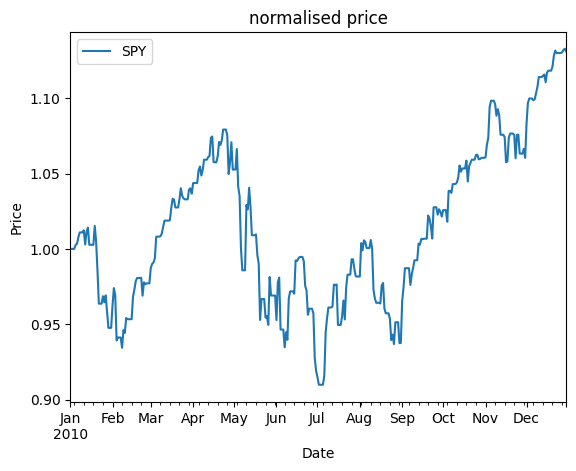

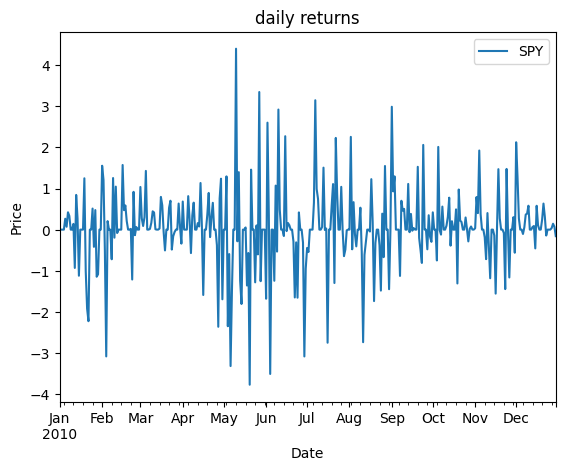

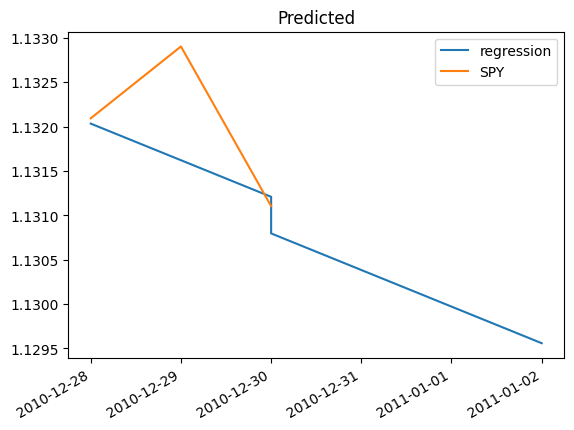

In [416]:
if __name__ == '__main__':
    test_run()

    # profile the performance of the code
    # cProfile.run("test_run()")


In [252]:
### NOTES:

# use fillna(method='ffill') for forward fill of NaN values 












### Feature engineering